In [15]:
import shutup
import msprime
import torch
from torch_geometric.loader import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from tsgcn.simulation import MsprimeSimulation, run_sims
from tsgcn.util import get_idle_gpu
from tsgcn.data import TreeSequenceData, TreeSequencesDataset, windowed_div_from_ts, compute_ys
from tsgcn.model import BiGCNModel, BiGCNEncoder

import tskit

shutup.please()

In [16]:
# this device variable will get used later during training
device = torch.device(f"cuda:{get_idle_gpu()}" if torch.cuda.is_available() else "cpu")
print(device)

cuda:1


In [22]:
## CONSTANTS
seed = 123117
num_reps = 1
sp_name = "HomSap"
chrom = None
length = 10_000_000
model_name ="OutOfAfrica_3G09"
sample_size=10
num_windows=1
HomSap_1Mb_OOA = MsprimeSimulation(seed, num_reps, sp_name, model_name, "test/raw/", chrom, length, sample_size, n_workers=512)

In [23]:
HomSap_1Mb_OOA.contig.recombination_map = msprime.RateMap(position=[0,400_000,600_000,1_000_000], rate=[1e-8, 0,1e-8])

In [24]:
run_sims(HomSap_1Mb_OOA)


In [25]:
HomSap_1Mb_OOA.sims_path

'test/raw/HomSap/10000000/OutOfAfrica_3G09/'

In [26]:
# Importing our dataset
dataset = TreeSequencesDataset("test/", HomSap_1Mb_OOA.sims_path,seeds=HomSap_1Mb_OOA.seed_array, y_name="windowed-diversity")
compute_ys(dataset, windowed_div_from_ts, "windowed-diversity", num_windows=num_windows, n_workers=256)


In [27]:
breaks = np.linspace(0, HomSap_1Mb_OOA.contig.length, num_windows+1)

In [28]:
encoder = BiGCNEncoder(breaks, device, dataset[0].num_features, 2)

In [29]:
out = encoder(dataset[0])

In [30]:
ts = tskit.load(dataset.raw_file_names[0])

In [31]:
ts.num_nodes

999

In [32]:
edges = ts.tables.edges

In [33]:
nodes_age = np.zeros(ts.num_nodes)
nodes_overlap = np.zeros(ts.num_nodes)

In [34]:
get_node_span = lambda nid, edges: [np.min(edges[np.logical_or(edges.child==nid,edges.parent==nid)].left), 
             np.max(edges[np.logical_or(edges.child==nid,edges.parent==nid)].right)]

In [35]:
dead_zone = [400_000, 600_000]

In [36]:
def get_intersection_overlap(a, b):
    """
    Returns the intersection over union of two bounding boxes.
    Note, lower and upper bounds intersect exactly, it is considered not an intersection.

    ref:
        - https://stackoverflow.com/a/2953979/1601580
    """
    return max(0, min(a[1], b[1]) - max(a[0], b[0]))

In [37]:
for node in ts.nodes():
    nid = node.id
    node_span = get_node_span(nid, edges)
    op = get_intersection_overlap(node_span, dead_zone)/np.diff(node_span)[0]
    nodes_age[nid] = node.time
    nodes_overlap[nid] = op


In [38]:
out.shape

torch.Size([999, 2])

In [39]:
nodes_overlap.shape

(999,)

Let's see how the relationship between the two dimensions the encoder outputs.

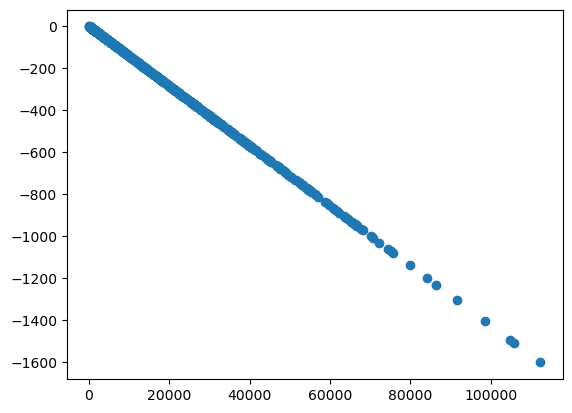

In [40]:
plt.plot(out[:,1].detach().numpy(), out[:,0].detach().numpy(), 'o')

Now checking the correlation between node time and the node embeddings. See how they are highly correlated, but less so in the case of younger nodes.

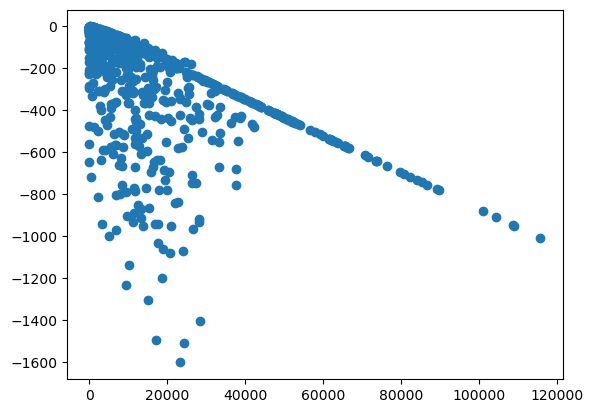

In [41]:
plt.plot(nodes_age, out[:,0].detach().numpy(), 'o')

Correlation between the overlap of the node span with the dead zone in recombination rate and the node embeddings.

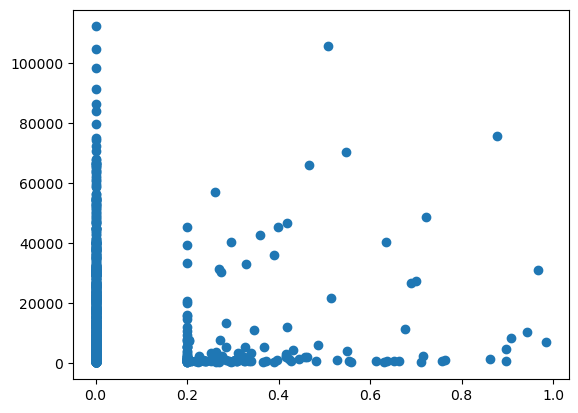

In [44]:
plt.plot(nodes_overlap, out[:,1].detach().numpy(), 'o')

Now just confirming there is no correlation between node age and node overlap with dead zone

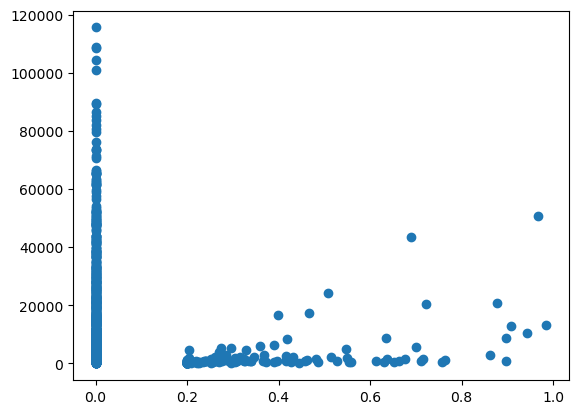

In [43]:
plt.plot(nodes_overlap, nodes_age, 'o')